In [2]:
import ee
ee.Authenticate()

Enter verification code: 4/1ARtbsJqb8MAgar5qo4yHVQ38x8F8iubo6ApwBwgVJXbcvsgjYXlEIJhqapk

Successfully saved authorization token.


In [3]:
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

NASADEM: NASA NASADEM Digital Elevation 30m


In [4]:
import math

def get_scale(width: float, 
              height: float, 
              resolution: int=10,
              max_element=1e5) -> int:
    area = height/resolution * width/resolution
    if area < max_element:
        return resolution
    scale = math.ceil(area / max_element)
    return scale * resolution

In [5]:
from shapely.affinity import translate, scale
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import transform
import pyproj

def convert_polygon(shapely_polygon: [Polygon, MultiPolygon],
                    crs: str = 'EPSG:4326') -> ee.Geometry.Polygon:
    projection = ee.Projection(crs)
    # if geometry not single polygon but multipolygon
    if isinstance(shapely_polygon, MultiPolygon):
        polygons = list(shapely_polygon)
        coords = [np.dstack((p.exterior.coords.xy)).tolist() for p in polygons]
        ee_polygon = ee.Geometry.MultiPolygon(coords, proj=projection)
        return ee_polygon

    x, y = shapely_polygon.exterior.coords.xy
    ee_polygon = ee.Geometry.Polygon(
        np.dstack((x, y)).tolist(), proj=projection)
    return ee_polygon

In [6]:
import numpy as np

def get_band(tile: ee.image.Image,
             aoi: ee.Geometry.Polygon, 
             band: str) -> np.array:

    array = np.array(tile.sampleRectangle(aoi).get(band).getInfo())
    return array

In [7]:
def transform_crs(geometry: Polygon,
                  source_crs: str,
                  destination_crs: str) -> Polygon:

    reproject = pyproj.Transformer.from_proj(
        pyproj.Proj(source_crs),
        pyproj.Proj(destination_crs),
        always_xy=True)
    new_geometry = transform(reproject.transform, geometry)
    return new_geometry

In [8]:
import os
import geopandas as gpd

mapinfo_dir = '/home/alex/mybox/IRB/CHAES/Сукцессии/ИнструментарийMapInfo'
data_file = 'agro32636.TAB'
# reading MapInfo .TAB-file directly into geopandas dataframe
formeragro_df = gpd.read_file(os.path.join(mapinfo_dir, data_file))

formeragro_df['area_ha'] = formeragro_df.geometry.area/10000
formeragro_df = formeragro_df[formeragro_df['area_ha'] > 0.01]
formeragro_df.head()

,id,region,district,number,owner,LONG,LAT,bush,tree_diameter,hummock,...,iMaxBqSr,iAvgBqSr,iMinKBqSr,iMaxKBqSr,iAvgKBqSr,iMinCiSr,iMaxCiSr,iAvgCiSr,geometry,area_ha
0,1,Гомельская область,Брагинский,1,"КСУП с-з ""Комаринский""",30.602005,51.299047,60,10,0,...,13.8,13.800000,3.73,3.73,3.73,0.10,0.10,0.100000,"POLYGON ((334269.320 5686366.870, 334264.910 5...",316.682644
1,2,Гомельская область,Брагинский,2,"КСУП с-з ""Комаринский""",30.589781,51.321111,23,16,0,...,22.1,22.100000,5.97,5.97,5.97,0.16,0.16,0.160000,"POLYGON ((331652.610 5688525.660, 331703.700 5...",28.079599
2,3,Гомельская область,Брагинский,3,"КСУП с-з ""Комаринский""",30.608144,51.361610,30,15,0,...,21.0,18.366667,4.32,5.67,4.96,0.12,0.15,0.133333,"POLYGON ((332522.410 5690363.310, 332925.510 5...",1353.279666
3,4,Гомельская область,Брагинский,4,"КСУП с-з ""Комаринский""",30.605730,51.408889,25,15,0,...,27.1,17.733333,2.32,7.32,4.79,0.06,0.20,0.130000,"POLYGON ((335363.870 5695467.490, 335391.770 5...",854.056080
4,5,Гомельская область,Брагинский,5,"КСУП с-з ""Комаринский""",30.577328,51.485771,5,10,0,...,132.9,132.900000,35.88,35.88,35.88,0.97,0.97,0.970000,"POLYGON ((331358.050 5706720.990, 331395.210 5...",18.310009


In [9]:
startDate = '2015-04-01'
endDate = '2015-08-31'
formeragro_df.geometry.crs

<Derived Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Turkey. Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
formeragro_df.geometry = formeragro_df.geometry.to_crs('EPSG:4326')

In [11]:
roi = formeragro_df.loc[formeragro_df['id'] == 11, 'geometry']

<AxesSubplot:>

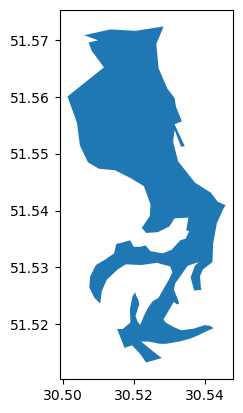

In [12]:
from matplotlib import pyplot as plt
roi.plot()

In [13]:
aoi = convert_polygon(roi.iloc[0])

In [14]:
dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
        .filterBounds(aoi)
        .filterDate(startDate, endDate)
        .filter(ee.Filter.contains('.geo', aoi.buffer(5e2))))
dw.size().getInfo()

42

In [15]:
crs_dw = dw.first().projection().crs().getInfo()
crs_dw

'EPSG:32635'

In [16]:
mask = transform_crs(roi.iloc[0], 'EPSG:4326', crs_dw)
mask.bounds

(742679.2105417094, 5712796.230581753, 745875.999319196, 5719375.947338773)

In [17]:
width = mask.bounds[2] - mask.bounds[0]
height = mask.bounds[3] - mask.bounds[1]
width, height

(3196.7887774865376, 6579.716757019982)

In [18]:
mask = translate(mask, -mask.bounds[0], -mask.bounds[1])
mask.bounds

(0.0, 0.0, 3196.7887774865376, 6579.716757019982)

In [19]:
BANDS = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
        'built', 'bare', 'snow_and_ice']

In [20]:
# appropriate scale optimize number of elements returned from GEE
scale_dw = get_scale(width=width, height=height)

projection = ee.Projection(crs_dw).atScale(scale_dw)
probabilityCol = dw.select(BANDS)
meanProbability = probabilityCol.reduce(ee.Reducer.mean())
meanProbability = meanProbability.setDefaultProjection(projection)

In [21]:
meanProbability.bandNames().getInfo()

['water_mean',
 'trees_mean',
 'grass_mean',
 'flooded_vegetation_mean',
 'crops_mean',
 'shrub_and_scrub_mean',
 'built_mean',
 'bare_mean',
 'snow_and_ice_mean']

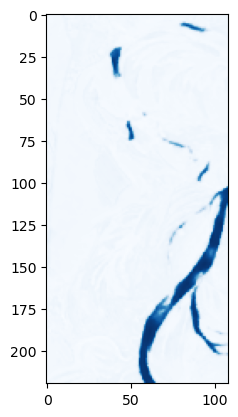

In [22]:
prob_array = get_band(tile=meanProbability,
                      aoi=aoi,
                      band='water_mean')
plt.imshow(prob_array, cmap='Blues')

In [23]:
prob_array.shape

(220, 108)

(0.033436089747370855, 0.03378390238372726, (220, 108))

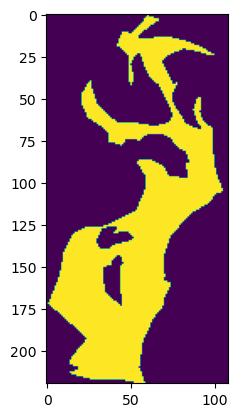

In [24]:
import rasterio.features

x_scale = prob_array.shape[0]/mask.bounds[3]
y_scale = prob_array.shape[1]/mask.bounds[2]
mask = scale(geom=mask, xfact=x_scale,
             yfact=y_scale, origin=(0, 0))
mask = rasterio.features.rasterize([mask.buffer(-1)],
                                    prob_array.shape).astype(bool)
plt.imshow(mask)
x_scale, y_scale, mask.shape

In [149]:
mean_probabilities = {}
x_scale = 0
for band in BANDS:
    prob_array = get_band(tile=meanProbability,
                          aoi=aoi,
                          band=band+'_'+'mean')
    prob_array = np.ma.masked_array(prob_array, mask=~mask)
    mean_probabilities[band] = np.mean(prob_array[~prob_array.mask])
mean_probabilities

{'water': 0.05086771683274487,
 'trees': 0.2756481805577417,
 'grass': 0.16459090040500846,
 'flooded_vegetation': 0.04399863482355261,
 'crops': 0.12902346566230963,
 'shrub_and_scrub': 0.20653299645133133,
 'built': 0.034738799193046344,
 'bare': 0.053535956151256336,
 'snow_and_ice': 0.03943510197145783}

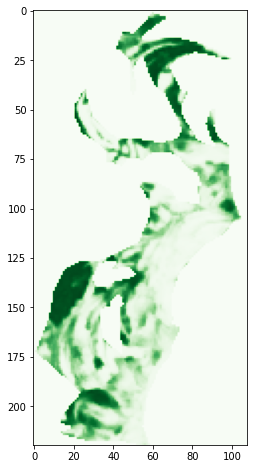

In [150]:
prob_array = get_band(tile=meanProbability,
                      aoi=aoi,
                      band='trees_mean')
plt.figure(figsize=(4,8))
im = plt.imshow((mask * prob_array), cmap='Greens')

In [151]:
import sys
libfolder = os.path.expanduser('~/mybox/eScience_ns/mylibs')
sys.path.append(libfolder)
from gdw_aggregation import gdwprobabilities as gdw

prob_bands_2015 = {band: band+'_2015' for band in gdw.BANDS}

In [163]:
site = formeragro_df.loc[formeragro_df['id'] == 11, 'geometry'].squeeze()
gdw.gdw_get_mean_probabilities(polygon=site,
                               crs=formeragro_df.crs,
                               startDate=startDate,
                               endDate=endDate)

{'water': 0.05086771683274487,
 'trees': 0.2756481805577417,
 'grass': 0.16459090040500846,
 'flooded_vegetation': 0.04399863482355261,
 'crops': 0.12902346566230963,
 'shrub_and_scrub': 0.20653299645133133,
 'built': 0.034738799193046344,
 'bare': 0.053535956151256336,
 'snow_and_ice': 0.03943510197145783}